<a href="https://colab.research.google.com/github/BabarMuaz/skinDiseaseDetection/blob/main/Longtraining_2x_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# copy data to colab dir
!cp -rf /content/drive/MyDrive/Splitted_SuperCleanedDataset_70_20_10 /content

# to remove this folder
#%rm -rf Splitted_SuperCleanedDataset_70_20_10 

In [3]:
# imporitng required libraries

#general
import itertools
import numpy as np # it is confusion matrix and classification function dependency 
import matplotlib.pyplot as plt #  it is training plots func dependency

# tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model 
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint # to save model and early stopping
from tensorflow.keras.metrics import categorical_crossentropy # loss function
from tensorflow.keras import layers # used when model is build Sequentially
from tensorflow.keras.preprocessing.image import ImageDataGenerator # data processing function
from tensorflow.keras.optimizers import Adam # optimizer
# sklearn
from sklearn.metrics import classification_report,confusion_matrix # to generate confusion matrix and classification summary

In [4]:
# get paths to fetch data
train_path = "/content/Splitted_SuperCleanedDataset_70_20_10/train"
valid_path = "/content/Splitted_SuperCleanedDataset_70_20_10/val"
test_path = "/content/Splitted_SuperCleanedDataset_70_20_10/test"

In [5]:
# Create Data Batches for training
size = 224

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.densenet.preprocess_input).flow_from_directory(
                                         directory=train_path, 
                                         target_size=(size,size),  
                                         batch_size=3904,
                                         #classes=['melanoma', 'nevus'], 
                                         class_mode='binary',
                                         shuffle=False)

valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.densenet.preprocess_input).flow_from_directory(
                                         directory=valid_path, target_size=(size,size),
                                         batch_size=1088,
                                         #classes=['melanoma', 'nevus'], 
                                         class_mode='binary',
                                         shuffle=False)

test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.densenet.preprocess_input).flow_from_directory(
                                         directory=test_path, 
                                         target_size=(size,size), 
                                         batch_size=564,
                                         #classes=['melanoma', 'nevus'], 
                                         class_mode='binary',
                                         shuffle=False)

Found 3904 images belonging to 2 classes.
Found 1088 images belonging to 2 classes.
Found 564 images belonging to 2 classes.


In [6]:
# checking how classes are labelled, somestimes depending on the server folders are stored alphabatelly or not
print("training data labelled as = ",train_batches.class_indices)
print("validation data labelled as = ",valid_batches.class_indices)
print("testing data labelled as = ",test_batches.class_indices)

training data labelled as =  {'melanoma': 0, 'nevus': 1}
validation data labelled as =  {'melanoma': 0, 'nevus': 1}
testing data labelled as =  {'melanoma': 0, 'nevus': 1}


In [7]:
(x_train, y_train) = next(train_batches)  # creating one batch for training images, purpose is to put data on ram faster execution

In [8]:
(x_test, y_test) = next(valid_batches)  # creating one batch for validation images, purpose is to put data on ram faster execution

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

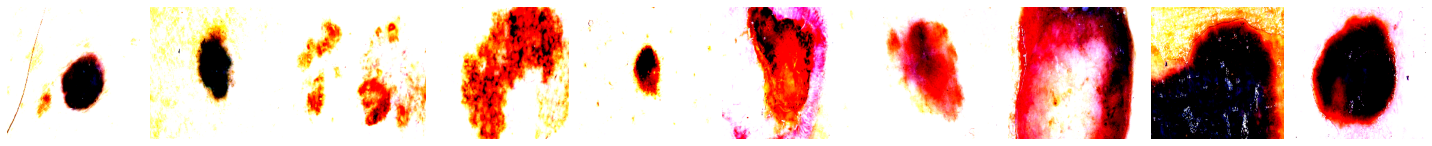

[0. 0. 0. ... 1. 1. 1.]


In [9]:
# function to see images in Datagen, this is used to see images after preprocessing step
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()


plotImages(x_train)
print(y_train)

In [10]:
# above ImageDataGenerator function along with next is used to put data on ram
# when data is on ram training is very quick, CAUTION: only do this if your dataset can fit on ram
# if dataaugmentation, than apply here
# datagen = ImageDataGenerator(rotation_range=20,
#       width_shift_range=0.2,
#       height_shift_range=0.2,
#       shear_range=0.2,
#       zoom_range=0.2,
#       horizontal_flip=True,
#       vertical_flip=True,
#       fill_mode='nearest')  # data in batches is fed to model using this 

#datagen = ImageDataGenerator(horizontal_flip=True,vertical_flip=True)      
datagen = ImageDataGenerator()    

In [11]:
# Create a base Densenet model
base_model = tf.keras.applications.DenseNet201(weights='imagenet', 
                                include_top=False, 
                                input_shape=(size, size,3))
base_model.trainable = False
#training=False

# Create new model on top
inputs = tf.keras.Input(shape=(size, size, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
# x = tf.keras.layers.Dense(512)(x)
# x = tf.keras.layers.Dropout(0.1)(x)  # Regularize with dropout
# x = tf.keras.layers.Dense(128)(x)
# x = tf.keras.layers.Dropout(0.2)(x)  # Regularize with dropout
# x = tf.keras.layers.Dense(64)(x)
x = tf.keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)

model.summary()




74850304/74836368 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_average_pooling2d (G  (None, 1920)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1920)              0         
                                                                 
 dense (Dense)               (None, 1)                 1921      
                                                                 
Total params: 18,323,905
Trainable params: 1,921
Non-trainable

In [12]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.BinaryAccuracy()],
)



# train model
history = model.fit(datagen.flow(x_train, y_train, batch_size=10),
                    steps_per_epoch=x_train.shape[0]//10,
                    epochs = 20 , 
                    validation_data = (x_test, y_test))

Epoch 1/20
390/390 [==============================] - 48s 68ms/step - loss: 0.4390 - binary_accuracy: 0.7961 - val_loss: 0.3390 - val_binary_accuracy: 0.8520
Epoch 2/20
390/390 [==============================] - 22s 55ms/step - loss: 0.3419 - binary_accuracy: 0.8575 - val_loss: 0.3181 - val_binary_accuracy: 0.8768
Epoch 3/20
390/390 [==============================] - 22s 56ms/step - loss: 0.3302 - binary_accuracy: 0.8572 - val_loss: 0.3496 - val_binary_accuracy: 0.8750
Epoch 4/20
390/390 [==============================] - 21s 55ms/step - loss: 0.3291 - binary_accuracy: 0.8598 - val_loss: 0.3349 - val_binary_accuracy: 0.8392
Epoch 5/20
390/390 [==============================] - 21s 54ms/step - loss: 0.3111 - binary_accuracy: 0.8680 - val_loss: 0.2978 - val_binary_accuracy: 0.8750
Epoch 6/20
390/390 [==============================] - 21s 54ms/step - loss: 0.3042 - binary_accuracy: 0.8703 - val_loss: 0.2926 - val_binary_accuracy: 0.8741
Epoch 7/20
390/390 [==============================] 

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


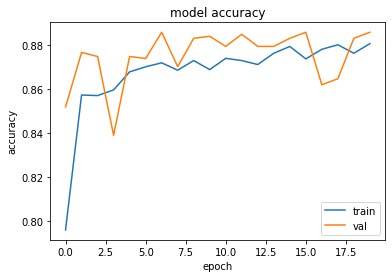

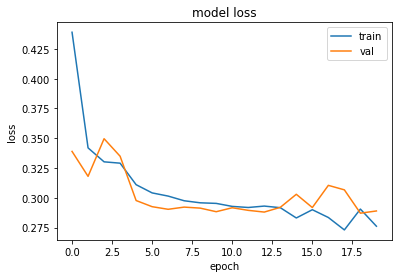

In [13]:
# Plot Training accuracy and loss grpahs

print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [14]:
base_model.trainable = True
model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.BinaryAccuracy()],
)


#create callback
filepath = 'best_model1x.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_binary_accuracy',
                             verbose=1, 
                             save_best_only=True,
                             mode='max')
callbacks = [checkpoint]

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_average_pooling2d (G  (None, 1920)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1920)              0         
                                                                 
 dense (Dense)               (None, 1)                 1921      
                                                                 
Total params: 18,323,905
Trainable params: 18,094,849
Non-trainable params: 229,056
___________________________________________

In [15]:
history = model.fit(datagen.flow(x_train, y_train, batch_size=10),
                    steps_per_epoch=x_train.shape[0]//10,
                    epochs = 50 , 
                    validation_data = (x_test, y_test),
                    callbacks = callbacks)

Epoch 1/50
390/390 [==============================] - ETA: 0s - loss: 0.3167 - binary_accuracy: 0.8626
Epoch 1: val_binary_accuracy improved from -inf to 0.87592, saving model to best_model1x.hdf5
390/390 [==============================] - 95s 185ms/step - loss: 0.3167 - binary_accuracy: 0.8626 - val_loss: 0.3343 - val_binary_accuracy: 0.8759
Epoch 2/50
390/390 [==============================] - ETA: 0s - loss: 0.2389 - binary_accuracy: 0.8921
Epoch 2: val_binary_accuracy did not improve from 0.87592
390/390 [==============================] - 65s 167ms/step - loss: 0.2389 - binary_accuracy: 0.8921 - val_loss: 0.3071 - val_binary_accuracy: 0.8410
Epoch 3/50
390/390 [==============================] - ETA: 0s - loss: 0.1694 - binary_accuracy: 0.9284
Epoch 3: val_binary_accuracy improved from 0.87592 to 0.88419, saving model to best_model1x.hdf5
390/390 [==============================] - 69s 176ms/step - loss: 0.1694 - binary_accuracy: 0.9284 - val_loss: 0.2532 - val_binary_accuracy: 0.884

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


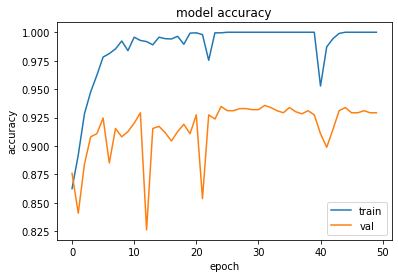

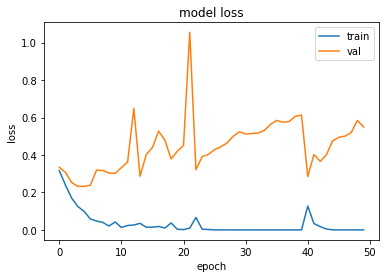

In [16]:
# Plot Training accuracy and loss grpahs

print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [17]:
# get testing data
(img, label) = next(test_batches)  # creating one batch for testing images, purpose is to put data on ram faster execution

In [18]:
predict_x=model.predict(img)
predictions = np.around(predict_x)
predictions = predictions.reshape(1,-1)[0]
a = predictions.clip(min=0)
a[a > 0] = 1

In [19]:
print(classification_report(label, a, target_names = ['melanoma','nevus']))

              precision    recall  f1-score   support

    melanoma       0.92      0.94      0.93       282
       nevus       0.94      0.92      0.93       282

    accuracy                           0.93       564
   macro avg       0.93      0.93      0.93       564
weighted avg       0.93      0.93      0.93       564



In [20]:
model = tf.keras.models.load_model('best_model1x.hdf5')

In [21]:
predict_x=model.predict(img)
predictions = np.around(predict_x)
predictions = predictions.reshape(1,-1)[0]
a = predictions.clip(min=0)
a[a > 0] = 1

In [22]:
# print classification sumamry
#predict_x=model.predict(img) 
#predictions=np.argmax(predict_x,axis=1)
#predictions = predictions.reshape(1,-1)[0]
#label=np.argmax(label,axis=1)
#label = label.reshape(1,-1)[0]
print(classification_report(label, a, target_names = ['melanoma','nevus']))

              precision    recall  f1-score   support

    melanoma       0.91      0.93      0.92       282
       nevus       0.93      0.91      0.92       282

    accuracy                           0.92       564
   macro avg       0.92      0.92      0.92       564
weighted avg       0.92      0.92      0.92       564



In [23]:
# This function is used to create Confusion Matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[263  19]
 [ 26 256]]


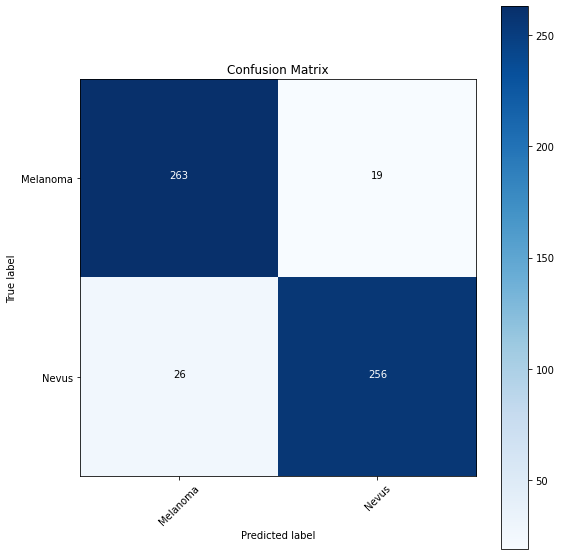

In [24]:
# calling confsion matrix function

cm_aug = confusion_matrix(label, a)
plot_confusion_matrix(cm_aug, classes = ['Melanoma','Nevus'], title='Confusion Matrix', normalize=False)

In [25]:
model.save('best_model1x.hdf5')
!cp /content/best_model1x.hdf5 /content/drive/MyDrive/Upwork/DiseaseClass

In [26]:
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(1e-5),  # Low learning rate
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.BinaryAccuracy()],
)


#create callback
filepath = 'best_model2x.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_binary_accuracy',
                             verbose=1, 
                             save_best_only=True,
                             mode='max')
callbacks = [checkpoint]

In [27]:
history = model.fit(datagen.flow(x_train, y_train, batch_size=10),
                    steps_per_epoch=x_train.shape[0]//10,
                    epochs = 10 , 
                    validation_data = (x_test, y_test),
                    callbacks = callbacks)

Epoch 1/10
390/390 [==============================] - ETA: 0s - loss: 0.0060 - binary_accuracy: 0.9977
Epoch 1: val_binary_accuracy improved from -inf to 0.92739, saving model to best_model2x.hdf5
390/390 [==============================] - 119s 204ms/step - loss: 0.0060 - binary_accuracy: 0.9977 - val_loss: 0.5044 - val_binary_accuracy: 0.9274
Epoch 2/10
390/390 [==============================] - ETA: 0s - loss: 0.0038 - binary_accuracy: 0.9982
Epoch 2: val_binary_accuracy did not improve from 0.92739
390/390 [==============================] - 74s 190ms/step - loss: 0.0038 - binary_accuracy: 0.9982 - val_loss: 0.6222 - val_binary_accuracy: 0.9246
Epoch 3/10
390/390 [==============================] - ETA: 0s - loss: 0.0015 - binary_accuracy: 0.9992
Epoch 3: val_binary_accuracy did not improve from 0.92739
390/390 [==============================] - 74s 190ms/step - loss: 0.0015 - binary_accuracy: 0.9992 - val_loss: 0.7519 - val_binary_accuracy: 0.9200
Epoch 4/10
390/390 [================

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


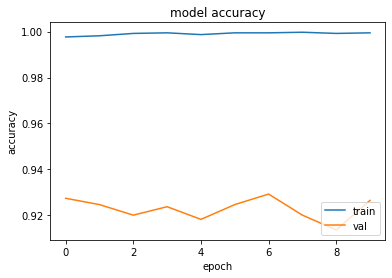

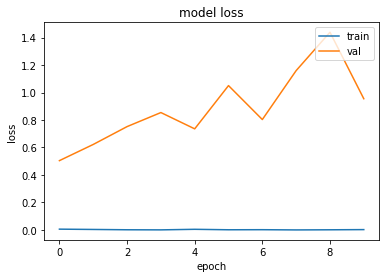

In [28]:
# Plot Training accuracy and loss grpahs

print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [29]:
predict_x=model.predict(img)
predictions = np.around(predict_x)
predictions = predictions.reshape(1,-1)[0]
a = predictions.clip(min=0)
a[a > 0] = 1

print(classification_report(label, a, target_names = ['melanoma','nevus']))

              precision    recall  f1-score   support

    melanoma       0.90      0.92      0.91       282
       nevus       0.92      0.90      0.91       282

    accuracy                           0.91       564
   macro avg       0.91      0.91      0.91       564
weighted avg       0.91      0.91      0.91       564



In [30]:
model = tf.keras.models.load_model('best_model2x.hdf5')

In [31]:
predict_x=model.predict(img)
predictions = np.around(predict_x)
predictions = predictions.reshape(1,-1)[0]
a = predictions.clip(min=0)
a[a > 0] = 1

In [32]:
print(classification_report(label, a, target_names = ['melanoma','nevus']))

              precision    recall  f1-score   support

    melanoma       0.91      0.92      0.92       282
       nevus       0.92      0.91      0.91       282

    accuracy                           0.91       564
   macro avg       0.91      0.91      0.91       564
weighted avg       0.91      0.91      0.91       564



Confusion matrix, without normalization
[[259  23]
 [ 25 257]]


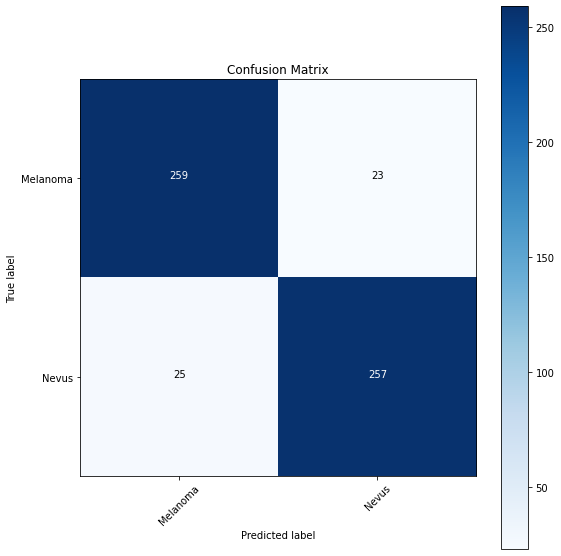

In [33]:
# calling confsion matrix function

cm_aug = confusion_matrix(label, a)
plot_confusion_matrix(cm_aug, classes = ['Melanoma','Nevus'], title='Confusion Matrix', normalize=False)

In [34]:
model.save('best_model2x.hdf5')
!cp /content/best_model2x.hdf5 /content/drive/MyDrive/Upwork/DiseaseClass

In [35]:
history = model.fit(datagen.flow(x_train, y_train, batch_size=10),
                    steps_per_epoch=x_train.shape[0]//10,
                    epochs = 30 , 
                    validation_data = (x_test, y_test),
                    callbacks = callbacks)

Epoch 1/30
390/390 [==============================] - ETA: 0s - loss: 0.0042 - binary_accuracy: 0.9990
Epoch 1: val_binary_accuracy improved from 0.92923 to 0.93750, saving model to best_model2x.hdf5
390/390 [==============================] - 107s 209ms/step - loss: 0.0042 - binary_accuracy: 0.9990 - val_loss: 0.8191 - val_binary_accuracy: 0.9375
Epoch 2/30
390/390 [==============================] - ETA: 0s - loss: 0.0017 - binary_accuracy: 0.9995
Epoch 2: val_binary_accuracy did not improve from 0.93750
390/390 [==============================] - 76s 195ms/step - loss: 0.0017 - binary_accuracy: 0.9995 - val_loss: 0.9877 - val_binary_accuracy: 0.9274
Epoch 3/30
390/390 [==============================] - ETA: 0s - loss: 0.0052 - binary_accuracy: 0.9987
Epoch 3: val_binary_accuracy did not improve from 0.93750
390/390 [==============================] - 76s 195ms/step - loss: 0.0052 - binary_accuracy: 0.9987 - val_loss: 1.1351 - val_binary_accuracy: 0.9228
Epoch 4/30
390/390 [=============

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


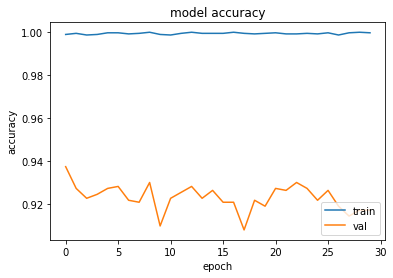

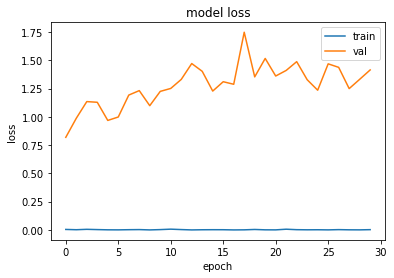

In [36]:
# Plot Training accuracy and loss grpahs

print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [37]:
predict_x=model.predict(img)
predictions = np.around(predict_x)
predictions = predictions.reshape(1,-1)[0]
a = predictions.clip(min=0)
a[a > 0] = 1

print(classification_report(label, a, target_names = ['melanoma','nevus']))

              precision    recall  f1-score   support

    melanoma       0.91      0.91      0.91       282
       nevus       0.91      0.91      0.91       282

    accuracy                           0.91       564
   macro avg       0.91      0.91      0.91       564
weighted avg       0.91      0.91      0.91       564



In [38]:
model = tf.keras.models.load_model('best_model2x.hdf5')

In [39]:
predict_x=model.predict(img)
predictions = np.around(predict_x)
predictions = predictions.reshape(1,-1)[0]
a = predictions.clip(min=0)
a[a > 0] = 1

print(classification_report(label, a, target_names = ['melanoma','nevus']))

              precision    recall  f1-score   support

    melanoma       0.92      0.93      0.92       282
       nevus       0.93      0.92      0.92       282

    accuracy                           0.92       564
   macro avg       0.92      0.92      0.92       564
weighted avg       0.92      0.92      0.92       564



In [40]:
model.save('best_model3x.hdf5')
!cp /content/best_model3x.hdf5 /content/drive/MyDrive/Upwork/DiseaseClass

In [42]:
correct = np.nonzero(predictions == label)[0]
incorrect = np.nonzero(predictions != label)[0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


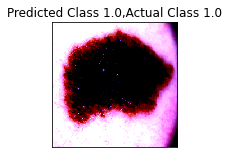

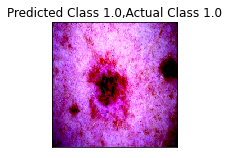

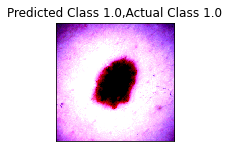

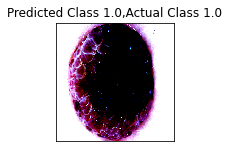

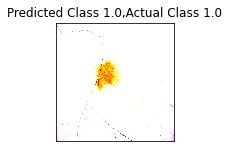

In [89]:
# Some of the Correctly Predicted Classes

i = 0
for c in correct[1:30]:
    #lt.subplot(3,2,i+1, figsize=(15,15))
    plt.figure(figsize=(10,10))
    plt.subplot(5,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img[c].reshape(224,224,3), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], label[c]))
    plt.tight_layout()
    i += 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


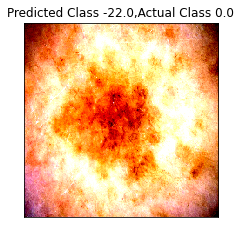

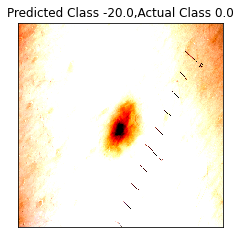

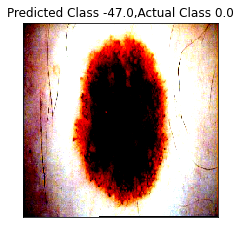

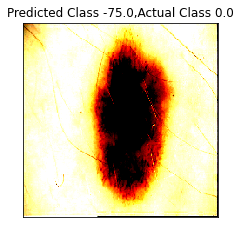

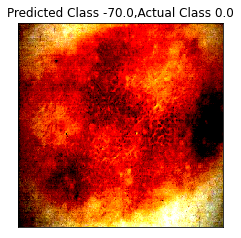

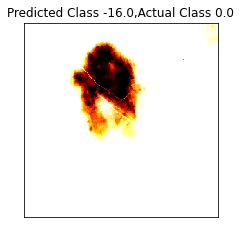

In [96]:
i = 0
for c in incorrect[250:256]:
    plt.figure(figsize=(10,10))
    plt.subplot(2,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img[c].reshape(224,224,3), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], label[c]))
    plt.tight_layout()
    i += 1